# Delhi AQI Analysis

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import statsmodels.api as sm


## Load Dataset

In [2]:
# Example - adjust path if needed
df = pd.read_csv("delhiaqi.csv")


df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    561 non-null    object 
 1   co      561 non-null    float64
 2   no      561 non-null    float64
 3   no2     561 non-null    float64
 4   o3      561 non-null    float64
 5   so2     561 non-null    float64
 6   pm2_5   561 non-null    float64
 7   pm10    561 non-null    float64
 8   nh3     561 non-null    float64
dtypes: float64(8), object(1)
memory usage: 39.6+ KB


,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000
mean,3814.942210,51.181979,75.292496,30.141943,64.655936,358.256364,420.988414,26.425062
std,3227.744681,83.904476,42.473791,39.979405,61.073080,227.359117,271.287026,36.563094
min,654.220000,0.000000,13.370000,0.000000,5.250000,60.100000,69.080000,0.630000
25%,1708.980000,3.380000,44.550000,0.070000,28.130000,204.450000,240.900000,8.230000
50%,2590.180000,13.300000,63.750000,11.800000,47.210000,301.170000,340.900000,14.820000
75%,4432.680000,59.010000,97.330000,47.210000,77.250000,416.650000,482.570000,26.350000
max,16876.220000,425.580000,263.210000,164.510000,511.170000,1310.200000,1499.270000,267.510000


In [3]:
df.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


## Data Cleaning (Handle Nulls, Duplicates, Date formatting)

In [5]:
# Drop duplicates
df = df.drop_duplicates()

# Check missing values
print(df.isnull().sum())


# Convert date column (adjust column name if different)
df['date'] = pd.to_datetime(df['date'])


date     0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64


## Feature Engineering (Extract month, season etc.)

In [6]:
# Extract month & year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day

# Define seasons for Delhi
def season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Summer'
    elif month in [6,7,8,9]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['season'] = df['month'].apply(season)

## AQI Calculation

In [9]:
df['AQI'] = df['pm2_5']

# Composite AQI
df['AQI_composite'] = df[['pm2_5','pm10','no2','o3','so2']].max(axis=1)

df[['date','AQI','AQI_composite']].head()

,date,AQI,AQI_composite
0,2023-01-01 00:00:00,169.29,194.64
1,2023-01-01 01:00:00,182.84,211.08
2,2023-01-01 02:00:00,220.25,260.68
3,2023-01-01 03:00:00,252.90,304.12
4,2023-01-01 04:00:00,266.36,322.80


## EDA - Visualizations

In [10]:
df.describe()


,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,month,year,day,AQI,AQI_composite
count,561,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.0,561.0,561.000000,561.000000,561.000000
mean,2023-01-12 16:00:00,3814.942210,51.181979,75.292496,30.141943,64.655936,358.256364,420.988414,26.425062,1.0,2023.0,12.192513,358.256364,421.589537
min,2023-01-01 00:00:00,654.220000,0.000000,13.370000,0.000000,5.250000,60.100000,69.080000,0.630000,1.0,2023.0,1.000000,60.100000,110.640000
25%,2023-01-06 20:00:00,1708.980000,3.380000,44.550000,0.070000,28.130000,204.450000,240.900000,8.230000,1.0,2023.0,6.000000,204.450000,240.900000
50%,2023-01-12 16:00:00,2590.180000,13.300000,63.750000,11.800000,47.210000,301.170000,340.900000,14.820000,1.0,2023.0,12.000000,301.170000,340.900000
75%,2023-01-18 12:00:00,4432.680000,59.010000,97.330000,47.210000,77.250000,416.650000,482.570000,26.350000,1.0,2023.0,18.000000,416.650000,482.570000
max,2023-01-24 08:00:00,16876.220000,425.580000,263.210000,164.510000,511.170000,1310.200000,1499.270000,267.510000,1.0,2023.0,24.000000,1310.200000,1499.270000
std,NaN,3227.744681,83.904476,42.473791,39.979405,61.073080,227.359117,271.287026,36.563094,0.0,0.0,6.756374,227.359117,270.597421


### AQI Over Time (Code)

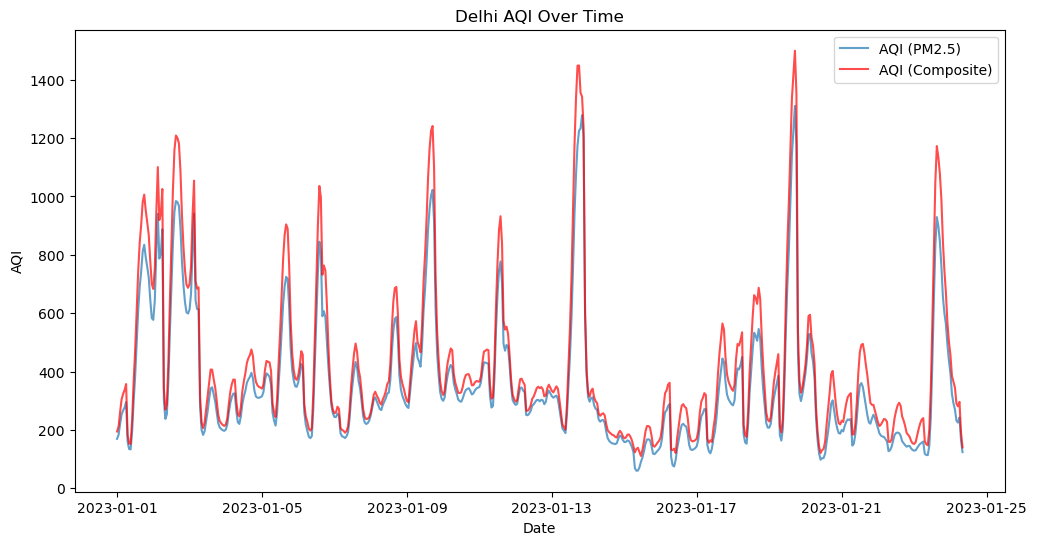

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['AQI'], label="AQI (PM2.5)", alpha=0.7)
plt.plot(df['date'], df['AQI_composite'], label="AQI (Composite)", alpha=0.7, color='red')
plt.title("Delhi AQI Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()


### Seasonal Trends

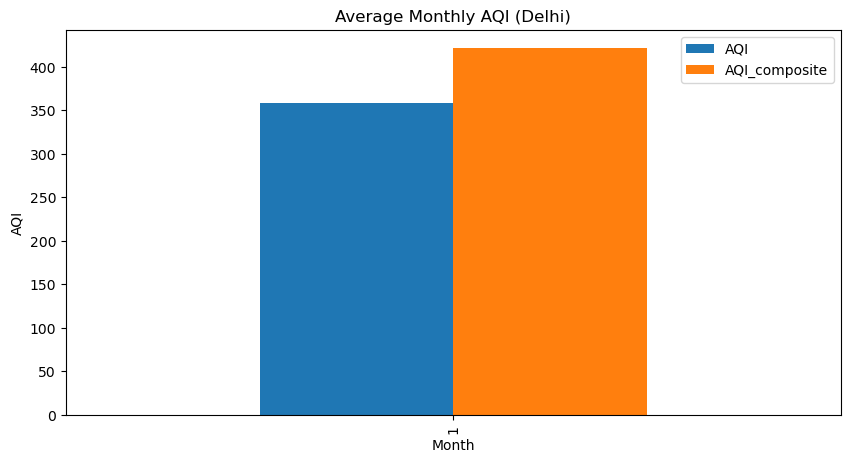

In [12]:
df['month'] = df['date'].dt.month
monthly = df.groupby('month')[['AQI','AQI_composite']].mean()

monthly.plot(kind='bar', figsize=(10,5))
plt.title("Average Monthly AQI (Delhi)")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.show()


### Pollutant Distributions

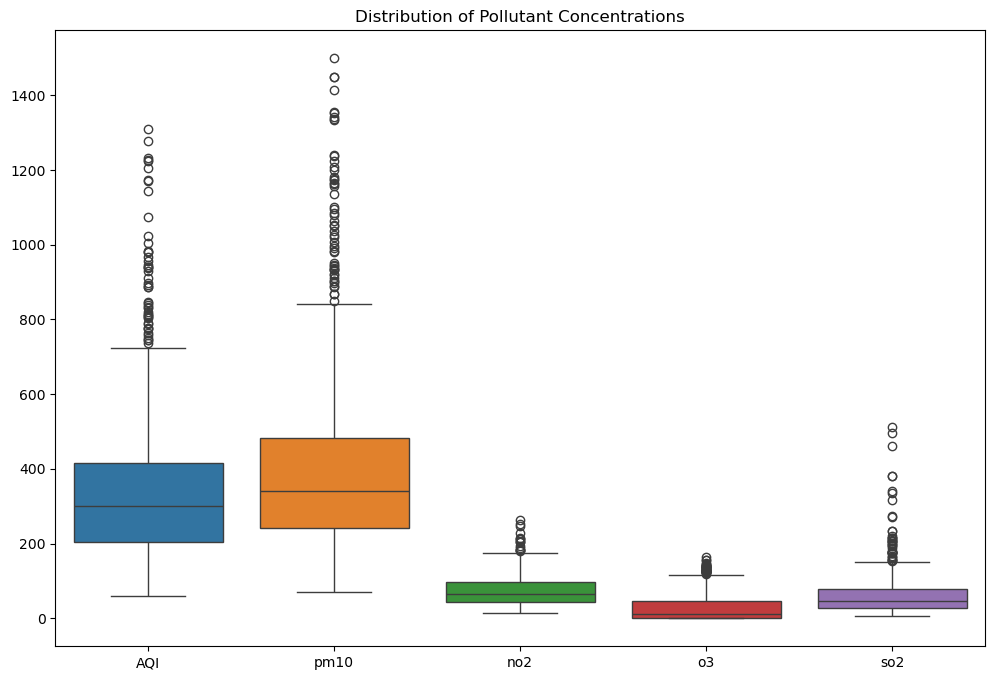

In [13]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df[['AQI','pm10','no2','o3','so2']])
plt.title("Distribution of Pollutant Concentrations")
plt.show()


### Correlation Heatmap

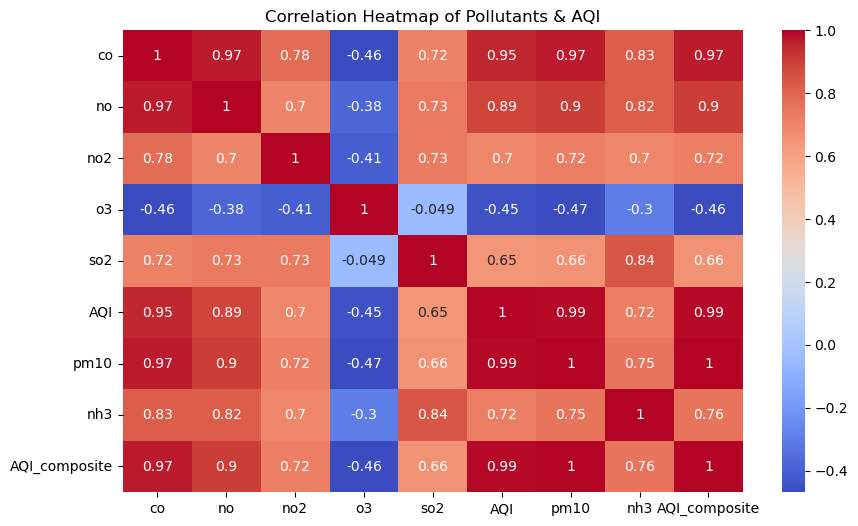

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['co','no','no2','o3','so2','AQI','pm10','nh3','AQI_composite']].corr(), 
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Pollutants & AQI")
plt.show()


## Insights & Observations

- **PM10 (r = 0.99)** is the strongest contributor to AQI, showing an almost perfect positive correlation.  
- **CO (r = 0.95)** and **NO (r = 0.89)** also have very strong positive correlations with AQI, indicating they are major pollutants driving poor air quality.  
- **NO2 (r = 0.70)**, **NH3 (r = 0.72)**, and **SO2 (r = 0.65–0.66)** show moderate positive correlations with AQI.  
- **Ozone (O3, r ≈ –0.45)** shows a negative correlation, suggesting higher O3 levels may coincide with slightly improved AQI conditions.  
- **Multicollinearity is high** among CO, PM10, and NO (correlations > 0.9), meaning these pollutants often rise together and may act as overlapping indicators.  
- Overall, **PM10, CO, and NO** are the dominant pollutants influencing AQI in this dataset, consistent with common sources like traffic emissions, industrial activities, and road dust in urban areas.